In [1]:
%matplotlib inline
import importlib
import math, keras, datetime, pandas as pd, numpy as np, keras.backend as K, threading, json, re, collections
import tarfile, tensorflow as tf, matplotlib.pyplot as plt, xgboost, operator, random, pickle, glob, os, bcolz
import shutil, sklearn, functools, itertools, scipy
from PIL import Image
import utils2;importlib.reload(utils2)

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<module 'utils2' from '/home/paperspace/fastai/courses/neural/utils2.py'>

In [2]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras.models import Model
from keras import metrics
from vgg16_avg import VGG16_Avg

In [3]:
def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

# allow_growth option,  attempts to allocate only as much GPU memory based on runtime allocations
limit_mem()

In [42]:
alpha=.005
beta=.995

In [11]:
path = '/home/paperspace/fastai/courses/neural/'
fnames=glob.glob(path+'*.jpg',recursive=True)
#style_file=fnames[0]
style_file=fnames[16]
content_file=fnames[8]


In [12]:
fnames

['/home/paperspace/fastai/courses/neural/girl-with-doll.jpg',
 '/home/paperspace/fastai/courses/neural/jojo-portrait.jpg',
 '/home/paperspace/fastai/courses/neural/shvi-mussorie.jpg',
 '/home/paperspace/fastai/courses/neural/amrita-shergill.jpg',
 '/home/paperspace/fastai/courses/neural/starry_night.jpg',
 '/home/paperspace/fastai/courses/neural/jojo-with-pk.jpg',
 '/home/paperspace/fastai/courses/neural/shivi-boston.jpg',
 '/home/paperspace/fastai/courses/neural/shivarati2.jpg',
 '/home/paperspace/fastai/courses/neural/fari2.jpg',
 '/home/paperspace/fastai/courses/neural/tar.jpg',
 '/home/paperspace/fastai/courses/neural/shivibose.jpg',
 '/home/paperspace/fastai/courses/neural/golden_gate.jpg',
 '/home/paperspace/fastai/courses/neural/the-scream.jpg',
 '/home/paperspace/fastai/courses/neural/fari.jpg',
 '/home/paperspace/fastai/courses/neural/IMG_0119.jpg',
 '/home/paperspace/fastai/courses/neural/red-fort.jpg',
 '/home/paperspace/fastai/courses/neural/gogh-portrait-small.jpg',
 '/hom

In [13]:
rn_mean=np.array([123.68, 116.779, 103.939],dtype=np.float32)
#preproc lambda
preproc= lambda x: (x-rn_mean)[:,:,:,::-1]

In [14]:
#deproc lambda
deproc= lambda x,s : np.clip(x.reshape(s)[:,:,:,::-1] +rn_mean,0,255)

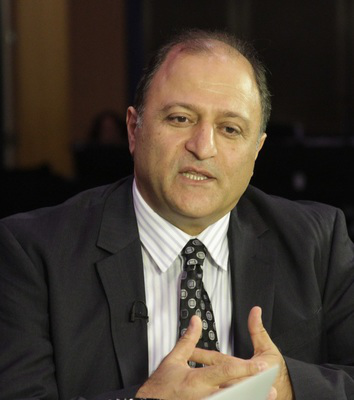

In [15]:
#read image into img
content_img=Image.open(content_file)
#resize content image to fit style image dimensions
c_w,c_h=content_img.size
content_img

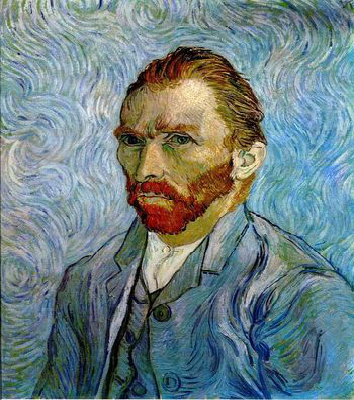

In [16]:
# read style imagesimg
style_img=Image.open(style_file)
simg=style_img.resize((c_w,c_h))
simg

In [17]:
#create numpy array from image, preprocess and expand dimension
content_img_arr=preproc(np.expand_dims(np.array(content_img),0))
shp=content_img_arr.shape
shp

(1, 400, 354, 3)

In [18]:
style_img_arr=preproc(np.expand_dims(np.array(simg),0)[:,:,:,:3])
style_source=style_img_arr
style_shp=style_source.shape
style_shp

(1, 400, 354, 3)

In [19]:
#create vgg 16 model without the final dense layers
vgg_model=VGG16_Avg(include_top=False,input_shape=shp[1:])
#vgg_model.summary()
# get the conv layer  output that we need for content
#layer model
block4_output=vgg_model.get_layer('block4_conv2').output
content_model=Model(vgg_model.input,block4_output)

In [20]:
# register a tensorflow variable for the target
content_target=K.variable(content_model.predict(content_img_arr),name="content_target")

In [21]:
class Evaluator:
        def __init__(self,f,shp):
                self.f=f
                self.shp=shp
        # loss. input x has to be reshaped as we gave a flattened array
        def loss(self,x):
                #ensure you pass a list or tuple as Keras functions expect that!
                loss,self.grad_values=self.f([x.reshape(self.shp)])
                return loss.astype(np.float64)

        # gradient.  note we need to give a flattened array to lbgfs
        def gradients(self,x):
                return self.grad_values.flatten().astype(np.float64)

In [22]:
content_loss=K.mean(metrics.mse(block4_output,content_target))
content_grads=K.gradients(content_loss,vgg_model.input)
fc=K.function([vgg_model.input],[content_loss]+content_grads)
evaluator=Evaluator(fc,shp)

In [23]:
def refine_image(no_iter,eval_obj,x):
        for i in range(no_iter):
                # here x is the initial guess
                x,min_val,info=fmin_l_bfgs_b(eval_obj.loss,x.flatten(), fprime=eval_obj.gradients)
                x=np.clip(x,-127,127)
                print ("current loss:"+str(min_val))
                imsave(f'{path}results/res_iter{i}.png',deproc(x.copy(),shp)[0])
        return x

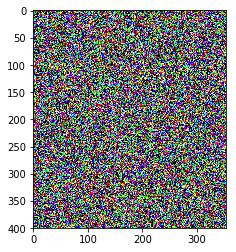

In [24]:
rand_img= lambda shape: np.random.uniform(-25,25,shape)/10
x=np.clip(rand_img(shp),0,1)
plt.imshow(x[0]);


In [25]:
style_outputs={ l.name:l.output  for l in vgg_model.layers}

In [26]:
#create the style model- has one input but multiple outputs
style_layers=[ style_outputs[f'block{i}_conv1'] for i in range(1,6)]
style_model=Model(vgg_model.input,style_layers)
style_targets=[K.variable(v,name=f"style_target{counter}") for counter,v in enumerate(style_model.predict(style_source))]

In [27]:
def gram_matrix(x):
    #first reorder dimensions such that the layer is the first dimension ( batch)
    #then call batch flatten, which will transform an nD vector into 2 D, i.e. all samples of a batch will be flattened
    #thus we end up having a 1D  array of activation values for each layer
    features=K.batch_flatten(K.permute_dimensions(x,(2,0,1)))
    return K.dot(features,K.transpose(features)) /x.get_shape().num_elements()

In [28]:
def style_loss(x,target) :  return K.mean(metrics.mse(gram_matrix(x),gram_matrix(target)))  

In [43]:
style_weights = [0.3,0.3,0.3,0.1,0.1]

In [44]:
# now we have to add the content loss and style loss
# style loss has to be weighted
#generator expression to sum total style loss
total_loss=beta*sum(style_loss(l1[0],l2[0])*w for l1,l2,w in zip(style_layers,style_targets,style_weights))
total_loss+=(content_loss*alpha)
final_grads=K.gradients(total_loss,vgg_model.input)
f_total=K.function([vgg_model.input],[total_loss]+final_grads)
ev=Evaluator(f_total,shp)

current loss:10.46389389038086


/home/paperspace/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  import sys


current loss:10.46550178527832
current loss:10.365077018737793
current loss:10.285750389099121
current loss:10.401617050170898
current loss:10.51508617401123
current loss:10.262312889099121
current loss:10.367051124572754
current loss:10.47463321685791
current loss:10.377718925476074


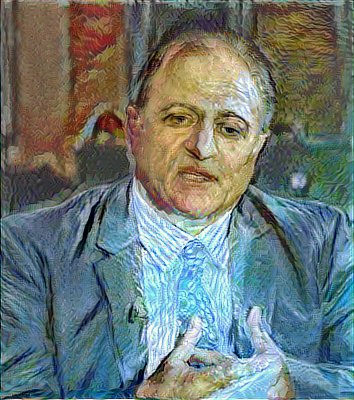

In [45]:
iters=10
#x = rand_img(shp)
x=content_img_arr
refine_image(iters,ev,x)
Image.open(f'{path}/results/res_iter9.png')